### Ver5 Enhanced with Spectral Attention and Multi-Objective Loss

Update di versi 4 :
- Ada Spectral Attention
- Ada Multi-Objective Loss
- Ada mekanisme early stopping
- Beberapa peningkatan di proses evaluasi
- Perbaikan data splitting dll, class-balanced sampling, disable boundary loss, focal gamma 4.0, reduced dropout, warmup LR scheduler, fixed colormap loading

In [1]:
# ===========================================
# Cell 1. Import Library dan Setup Environment
# ===========================================

import os
import json
import random
from pathlib import Path
from collections import Counter, defaultdict

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from scipy.ndimage import distance_transform_edt

# Gunakan GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device yang digunakan:", device)

# Monitor GPU memory
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Total Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Device yang digunakan: cuda
GPU: NVIDIA GeForce RTX 4080 SUPER
Total Memory: 17.17 GB


In [2]:
# ===========================================
# Cell 2. Fungsi Bantuan Umum + FIXED Colormap Loader
# ===========================================

from matplotlib.colors import ListedColormap

def seed_everything(seed=42):
    """Menetapkan seed random agar hasil eksperimen bisa direplikasi"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

seed_everything(42)


def load_colormap_from_json(json_path, label_remap, num_classes):
    """
    FIXED: Load colormap dari label_classes.json dengan mapping yang benar
    
    Args:
        json_path: Path ke label_classes.json
        label_remap: Dictionary {original_label: new_index}
        num_classes: Jumlah kelas setelah remapping
    
    Returns:
        ListedColormap dengan warna yang sesuai
    """
    if not os.path.exists(json_path):
        print("[WARNING] label_classes.json not found! Using default colors")
        return ListedColormap(['black'] + [plt.cm.tab20(i) for i in range(num_classes-1)])
    
    with open(json_path, 'r') as f:
        label_info = json.load(f)
    
    # Reverse mapping: new_idx → orig_label
    reverse_map = {v: k for k, v in label_remap.items()}
    
    # Mapping nama kelas ke warna (berdasarkan original dataset indices)
    # Original indices: {0, 8, 12, 13, 14, 18, 38}
    name_to_color = {}
    for cls_info in label_info:
        name_to_color[cls_info['name']] = cls_info['color'][:7]
    
    # Build color list
    colors = ['#000000']  # Background (index 0) always black
    
    # Manual mapping berdasarkan data Anda:
    # 0 → 0: Deep water (hitam)
    # 8 → 1: Sand (coklat muda)
    # 12 → 2: Kelp (coklat)
    # 13 → 3: Laminaria hyperborea (ungu)
    # 14 → 4: Laminaria digitata (biru)
    # 18 → 5: Rockweed (hijau)
    # 38 → 6: Trawl track (merah)
    
    class_mapping = {
        0: 'Deep water',
        8: 'Sand',
        12: 'Kelp',
        13: 'Laminaria hyperborea',
        14: 'Laminaria digitata',
        18: 'Rockweed',
        38: 'Trawl track'
    }
    
    for new_idx in range(1, num_classes):
        if new_idx not in reverse_map:
            colors.append('#808080')  # Gray fallback
            continue
        
        orig_label = reverse_map[new_idx]
        class_name = class_mapping.get(orig_label, 'Unknown')
        
        color = name_to_color.get(class_name, '#808080')
        colors.append(color)
    
    print(f"[INFO] Loaded colormap with {len(colors)} colors")
    for i, (idx, color) in enumerate(zip(range(num_classes), colors)):
        if idx in reverse_map:
            orig = reverse_map[idx]
            name = class_mapping.get(orig, 'Unknown')
            print(f"  Class {idx} ({name}): {color}")
    
    return ListedColormap(colors)


def visualize_tile(x_tile, y_true=None, y_pred=None, cmap=None, idx=0):
    """
    UPDATED: Menampilkan citra tile dengan colormap yang benar
    """
    if isinstance(x_tile, torch.Tensor):
        x = x_tile.cpu().numpy()
        x = np.transpose(x, (1,2,0))
    else:
        x = x_tile

    # Pseudo-RGB
    B = x.shape[2]
    b1, b2, b3 = int(B*0.05), int(B*0.5), int(B*0.9)
    rgb = x[..., [b1, b2, b3]]
    rgb_norm = (rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-9)

    if cmap is None:
        cmap = "tab20"

    # Visualisasi
    fig, axes = plt.subplots(1, 3, figsize=(14, 4))
    
    axes[0].imshow(rgb_norm)
    axes[0].set_title("Pseudo-RGB", fontsize=11, fontweight='bold')
    axes[0].axis('off')
    
    if y_true is not None:
        im1 = axes[1].imshow(y_true, cmap=cmap, vmin=0, vmax=6)
        axes[1].set_title("Ground Truth", fontsize=11, fontweight='bold')
        axes[1].axis('off')
        cbar1 = plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
        cbar1.set_label('Class', rotation=270, labelpad=15)
    
    if y_pred is not None:
        im2 = axes[2].imshow(y_pred, cmap=cmap, vmin=0, vmax=6)
        axes[2].set_title("Prediction", fontsize=11, fontweight='bold')
        axes[2].axis('off')
        cbar2 = plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)
        cbar2.set_label('Class', rotation=270, labelpad=15)
    
    plt.tight_layout()
    plt.show()

In [3]:
# ===========================================
# Cell 3. Dataset Loader + CLASS-BALANCED SAMPLING
# ===========================================

def load_label_mapping(json_path):
    """Membaca file label_classes.json untuk mapping id ke nama kelas"""
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    idx_to_name = {i: item["name"] for i, item in enumerate(data)}
    return idx_to_name

def normalize_reflectance(cube):
    """Menormalkan reflektansi 0-1 per tile, hemat RAM, aman untuk mmap read-only."""
    if not cube.flags.writeable:
        cube = cube.astype(np.float32, copy=True)

    if cube.dtype != np.float32:
        cube = cube.astype(np.float32, copy=False)

    np.nan_to_num(cube, copy=False)

    min_val = np.nanmin(cube)
    max_val = np.nanmax(cube)
    if max_val > min_val:
        cube -= min_val
        cube /= (max_val - min_val + 1e-8)

    return cube


class SeaweedDataset(Dataset):
    """
    IMPROVED: Dataset dengan class-balanced sampling
    """
    def __init__(self, data_files, label_map, tile_size=64, normalize=True, label_remap=None, augment=False):
        self.data_files = data_files
        self.label_map = label_map
        self.tile_size = tile_size
        self.normalize = normalize
        self.label_remap = label_remap
        self.augment = augment

        # Daftar pasangan (file_x, file_y)
        self.pairs = []
        for f in data_files:
            if f.endswith("_x.npy"):
                fy = f.replace("_x.npy", "_y.npy")
                if os.path.exists(fy):
                    self.pairs.append((f, fy))
        
        # Pre-filter tile kosong
        self.index = []
        print("[INFO] Pre-filtering empty tiles...")
        
        empty_count = 0
        valid_count = 0
        
        for file_idx, (fx, fy) in enumerate(self.pairs):
            x = np.load(fx, mmap_mode="r")
            y = np.load(fy, mmap_mode="r")
            H, W, _ = x.shape
            
            for i in range(0, H - tile_size + 1, tile_size):
                for j in range(0, W - tile_size + 1, tile_size):
                    y_tile = y[i:i+tile_size, j:j+tile_size]
                    
                    if np.any(y_tile > 0):
                        self.index.append((file_idx, i, j))
                        valid_count += 1
                    else:
                        empty_count += 1
            del x, y
            
        print(f"[INFO] Total tile valid: {valid_count}")
        print(f"[INFO] Total tile empty (filtered): {empty_count}")
        print(f"[INFO] Ratio valid/total: {valid_count/(valid_count+empty_count)*100:.2f}%")
        
        # IMPROVEMENT: Class-balanced sampling (hanya untuk training)
        if self.augment:
            print("[INFO] Applying class-balanced sampling...")
            
            # Group tiles by dominant class
            class_tiles = defaultdict(list)
            
            for idx, (file_idx, i, j) in enumerate(self.index):
                fy = self.pairs[file_idx][1]
                y = np.load(fy, mmap_mode="r")[i:i+tile_size, j:j+tile_size]
                
                # Remap
                if self.label_remap:
                    y_remap = np.zeros_like(y, dtype=np.int64)
                    for orig, new in self.label_remap.items():
                        y_remap[y == orig] = new
                    y = y_remap
                
                # Dominant class (excluding background)
                valid_mask = (y > 0)
                if valid_mask.sum() > 0:
                    dominant_class = np.bincount(y[valid_mask].flatten()).argmax()
                else:
                    dominant_class = 0
                
                class_tiles[dominant_class].append((file_idx, i, j))
            
            # Balanced sampling: target 200 tiles per class
            target_per_class = 200
            balanced_index = []
            
            for cls in range(1, len(self.label_remap)):  # Skip background
                if cls in class_tiles:
                    tiles = class_tiles[cls]
                    # Oversample minority, undersample majority
                    if len(tiles) < target_per_class:
                        sampled_idx = np.random.choice(len(tiles), target_per_class, replace=True)
                        balanced_index.extend([tiles[i] for i in sampled_idx])
                    else:
                        sampled_idx = np.random.choice(len(tiles), target_per_class, replace=False)
                        balanced_index.extend([tiles[i] for i in sampled_idx])
                    print(f"  Class {cls}: {len(tiles)} tiles → sampled {target_per_class}")
            
            # Add some background tiles (but not too many)
            if 0 in class_tiles:
                bg_tiles = class_tiles[0]
                bg_sample = min(len(bg_tiles), target_per_class // 2)
                sampled_idx = np.random.choice(len(bg_tiles), bg_sample, replace=False)
                balanced_index.extend([bg_tiles[i] for i in sampled_idx])
                print(f"  Class 0 (background): {len(bg_tiles)} tiles → sampled {bg_sample}")
            
            self.index = balanced_index
            print(f"[INFO] After balancing: {len(self.index)} tiles")
        
        print(f"[INFO] Total tile terdaftar: {len(self.index)} dari {len(self.pairs)} file")

    def __len__(self):
        return len(self.index)

    def __getitem__(self, idx):
        file_idx, i, j = self.index[idx]
        fx, fy = self.pairs[file_idx]
        
        # Memuat tile menggunakan mmap
        x = np.load(fx, mmap_mode="r")[i:i+self.tile_size, j:j+self.tile_size, :]
        y = np.load(fy, mmap_mode="r")[i:i+self.tile_size, j:j+self.tile_size]

        if self.normalize:
            x = normalize_reflectance(x)

        # REMAP label
        if self.label_remap is not None:
            y_remap = np.zeros_like(y, dtype=np.int64)
            for orig_label, new_idx in self.label_remap.items():
                y_remap[y == orig_label] = new_idx
            y = y_remap
        else:
            y = y.astype(np.int64)

        # Konversi ke tensor
        x_tensor = torch.tensor(x.transpose(2, 0, 1), dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.long)
        
        # Data Augmentation
        if self.augment:
            # Random horizontal flip
            if random.random() > 0.5:
                x_tensor = torch.flip(x_tensor, [2])
                y_tensor = torch.flip(y_tensor, [1])
            
            # Random vertical flip
            if random.random() > 0.5:
                x_tensor = torch.flip(x_tensor, [1])
                y_tensor = torch.flip(y_tensor, [0])
            
            # Random rotation 90/180/270
            k = random.choice([0, 1, 2, 3])
            if k > 0:
                x_tensor = torch.rot90(x_tensor, k, [1, 2])
                y_tensor = torch.rot90(y_tensor, k, [0, 1])
        
        return x_tensor, y_tensor


def detect_actual_classes(pairs):
    """Scan semua file y.npy untuk mendeteksi kelas yang benar-benar ada"""
    found = set()
    for _, fy in pairs:
        y = np.load(fy, mmap_mode="r")
        found |= set(np.unique(y))
    found = sorted(list(found))
    print(f"[INFO] Kelas AKTUAL yang ditemukan di dataset: {found}")
    return found

In [4]:
# ===========================================
# Cell 4. NOVELTY 1: Spectral Self-Attention Module
# ===========================================

class SpectralAttention(nn.Module):
    """
    Spectral Self-Attention Module
    Adaptively learns importance weights for spectral channels
    """
    def __init__(self, in_channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False)
        )
        
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        B, C, H, W = x.size()
        
        avg_out = self.avg_pool(x).view(B, C)
        max_out = self.max_pool(x).view(B, C)
        
        avg_weight = self.fc(avg_out)
        max_weight = self.fc(max_out)
        
        attention_weights = self.sigmoid(avg_weight + max_weight)
        
        out = x * attention_weights.view(B, C, 1, 1)
        
        return out, attention_weights

In [5]:
# ===========================================
# Cell 5. NOVELTY 2: Multi-Objective Loss (with Focal Loss)
# ===========================================

class FocalLoss(nn.Module):
    """
    Focal Loss for addressing class imbalance
    """
    def __init__(self, alpha=None, gamma=4.0, ignore_index=0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ignore_index = ignore_index
    
    def forward(self, pred, target):
        ce_loss = F.cross_entropy(pred, target, weight=self.alpha, 
                                  ignore_index=self.ignore_index, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma * ce_loss).mean()
        
        return focal_loss


class DiceLoss(nn.Module):
    """Dice Loss for region-level consistency"""
    def __init__(self, smooth=1.0, ignore_index=0):
        super().__init__()
        self.smooth = smooth
        self.ignore_index = ignore_index
    
    def forward(self, pred, target):
        pred = F.softmax(pred, dim=1)
        target_one_hot = F.one_hot(target, num_classes=pred.shape[1]).permute(0, 3, 1, 2).float()
        
        if self.ignore_index is not None:
            mask = (target != self.ignore_index).unsqueeze(1).float()
            pred = pred * mask
            target_one_hot = target_one_hot * mask
        
        intersection = (pred * target_one_hot).sum(dim=(2, 3))
        union = pred.sum(dim=(2, 3)) + target_one_hot.sum(dim=(2, 3))
        
        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        
        return 1 - dice.mean()


class BoundaryLoss(nn.Module):
    """Boundary Loss for edge precision (DISABLED in this version)"""
    def __init__(self, ignore_index=0):
        super().__init__()
        self.ignore_index = ignore_index
    
    def forward(self, pred, target):
        # Return zero loss (disabled)
        return torch.tensor(0.0, device=pred.device, requires_grad=True)


class HybridLoss(nn.Module):
    """
    IMPROVED: Multi-Objective Hybrid Loss
    - Focal gamma increased to 4.0
    - Boundary loss disabled
    """
    def __init__(self, weight_ce=1.0, weight_dice=1.0, weight_boundary=0.0, 
                 class_weights=None, ignore_index=0, focal_gamma=4.0):
        super().__init__()
        self.weight_ce = weight_ce
        self.weight_dice = weight_dice
        self.weight_boundary = weight_boundary
        
        self.ce_loss = FocalLoss(
            alpha=class_weights, 
            gamma=focal_gamma,
            ignore_index=ignore_index
        )
        self.dice_loss = DiceLoss(ignore_index=ignore_index)
        self.boundary_loss = BoundaryLoss(ignore_index=ignore_index)
    
    def forward(self, pred, target):
        loss_ce = self.ce_loss(pred, target)
        loss_dice = self.dice_loss(pred, target)
        loss_boundary = self.boundary_loss(pred, target)
        
        total_loss = (
            self.weight_ce * loss_ce +
            self.weight_dice * loss_dice +
            self.weight_boundary * loss_boundary
        )
        
        loss_dict = {
            'total': total_loss.item(),
            'focal': loss_ce.item(),
            'dice': loss_dice.item(),
            'boundary': loss_boundary.item()
        }
        
        return total_loss, loss_dict

In [6]:
# ===========================================
# Cell 6. Enhanced HybridSN + REDUCED Dropout
# ===========================================

class SpectralAttentionHybridSN(nn.Module):
    """
    IMPROVED: Reduced dropout from 0.3 to 0.2
    """
    def __init__(self, in_bands=300, num_classes=7, attention_reduction=16):
        super().__init__()
        
        # 3D Convolution layers
        self.conv3d_1 = nn.Conv3d(1, 16, (7,3,3), padding=(0,1,1))
        self.bn3d_1 = nn.BatchNorm3d(16)
        
        self.conv3d_2 = nn.Conv3d(16, 32, (5,3,3), padding=(0,1,1))
        self.bn3d_2 = nn.BatchNorm3d(32)
        
        self.conv3d_3 = nn.Conv3d(32, 64, (3,3,3), padding=(0,1,1))
        self.bn3d_3 = nn.BatchNorm3d(64)
        
        self.spectral_pool = nn.AdaptiveAvgPool3d((8, None, None))
        
        self.flatten_channels = 64 * 8
        
        # Spectral Attention
        self.spectral_attention = SpectralAttention(
            in_channels=self.flatten_channels,
            reduction=attention_reduction
        )
        
        # 2D Convolution layers (REDUCED DROPOUT)
        self.conv2d_1 = nn.Conv2d(self.flatten_channels, 256, 3, padding=1)
        self.bn2d_1 = nn.BatchNorm2d(256)
        self.dropout1 = nn.Dropout2d(0.2)  # REDUCED from 0.3
        
        self.conv2d_2 = nn.Conv2d(256, 128, 3, padding=1)
        self.bn2d_2 = nn.BatchNorm2d(128)
        self.dropout2 = nn.Dropout2d(0.2)  # REDUCED from 0.3
        
        self.conv2d_3 = nn.Conv2d(128, 64, 3, padding=1)
        self.bn2d_3 = nn.BatchNorm2d(64)
        
        self.classifier = nn.Conv2d(64, num_classes, 1)
        
        self.last_attention_weights = None

    def forward(self, x):
        B, Bands, H, W = x.shape
        
        # 3D CNN
        x3 = x.unsqueeze(1)
        x3 = F.relu(self.bn3d_1(self.conv3d_1(x3)))
        x3 = F.relu(self.bn3d_2(self.conv3d_2(x3)))
        x3 = F.relu(self.bn3d_3(self.conv3d_3(x3)))
        
        x3 = self.spectral_pool(x3)
        
        # Reshape
        B, C3, reduced_spec, H, W = x3.shape
        x2 = x3.view(B, C3 * reduced_spec, H, W)
        
        # Spectral Attention
        x2, attention_weights = self.spectral_attention(x2)
        self.last_attention_weights = attention_weights
        
        # 2D CNN
        x2 = self.dropout1(F.relu(self.bn2d_1(self.conv2d_1(x2))))
        x2 = self.dropout2(F.relu(self.bn2d_2(self.conv2d_2(x2))))
        x2 = F.relu(self.bn2d_3(self.conv2d_3(x2)))
        
        out = self.classifier(x2)
        
        return out
    
    def get_attention_weights(self):
        return self.last_attention_weights

In [7]:
# ===========================================
# Cell 7. STRATIFIED Data Split (FIXED)
# ===========================================

data_dir = "../data/npy_converted"
label_json_path = "../data/annotation/segmentation_masks/label_classes.json"

label_map = load_label_mapping(label_json_path)
print(f"Jumlah total kelas di JSON: {len(label_map)}")

# Ambil semua file
all_x_files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith("_x.npy")])
pairs = [(fx, fx.replace("_x.npy", "_y.npy")) for fx in all_x_files if os.path.exists(fx.replace("_x.npy", "_y.npy"))]

print(f"Total pasangan file X-Y ditemukan: {len(pairs)}")

# ============================================
# STRATIFIED SPLITTING (FIXED)
# ============================================

print("\n" + "="*60)
print("STRATIFIED DATA SPLITTING (IMPROVED)")
print("="*60)

# Based on Cell 15b analysis:
# Files with rare classes 4,5 must be in train!
# All splits must have diverse class coverage

# STRATIFIED SPLIT STRATEGY:
train_pairs = [
    pairs[0],   # 003: [0,3,4,5,6] ← CRITICAL for rare classes!
    pairs[1],   # 004: [0,2]
    pairs[2],   # 008: [0,2]
    pairs[4],   # 013: [0,1]
    pairs[5],   # 1228-004: [0,1]
    pairs[7],   # 1228-006: [0,1]
    pairs[9],   # 1228-012: [0,1,2,6]
    pairs[10],  # 1228-013: [0,3,6]
]

val_pairs = [
    pairs[3],   # 009: [0,2]
    pairs[11],  # 1228-014: [0,3,6]
    pairs[12],  # 1228-015: [0,3,6]
    pairs[13],  # 1228-016: [0,2]
]

test_pairs = [
    pairs[6],   # 1228-005: [0,1]
    pairs[8],   # 1228-009: [0,2]
    pairs[14],  # 1228-018: [0,3,6]
    pairs[15],  # 1228-019: [0,3,6]
    pairs[16],  # 1228-020: [0,3,6]
    pairs[17],  # 1228-021: [0,1]
]

print(f"Train : {len(train_pairs)} files")
print(f"Val   : {len(val_pairs)} files")
print(f"Test  : {len(test_pairs)} files")

# Verify coverage
def check_class_coverage(split_pairs, split_name):
    all_classes = set()
    for _, fy in split_pairs:
        y = np.load(fy, mmap_mode='r')
        all_classes |= set(np.unique(y))
    
    orig_classes_in_split = sorted(list(all_classes))
    print(f"\n{split_name}:")
    print(f"  Original classes: {orig_classes_in_split}")
    
    return all_classes

train_orig = check_class_coverage(train_pairs, "TRAIN")
val_orig = check_class_coverage(val_pairs, "VAL")
test_orig = check_class_coverage(test_pairs, "TEST")

# Detect actual classes
actual_classes = detect_actual_classes(train_pairs + val_pairs + test_pairs)
orig_classes = [int(x) for x in actual_classes]
label_remap = {orig: idx for idx, orig in enumerate(orig_classes)}
print(f"\n[INFO] Label remap: {label_remap}")

# Check remapped coverage
train_remapped = {label_remap[x] for x in train_orig if x in label_remap}
val_remapped = {label_remap[x] for x in val_orig if x in label_remap}
test_remapped = {label_remap[x] for x in test_orig if x in label_remap}

print(f"\nRemapped classes:")
print(f"  Train: {sorted(train_remapped)}")
print(f"  Val:   {sorted(val_remapped)}")
print(f"  Test:  {sorted(test_remapped)}")

missing_in_test = train_remapped - test_remapped
if missing_in_test:
    print(f"\n [WARNING]: Classes {sorted(missing_in_test)} missing in test!")
else:
    print(f"\n[OK] All classes present in test set!")

print("="*60)

# Create datasets
TILE_SIZE = 64  # Keep at 64

train_dataset = SeaweedDataset([p[0] for p in train_pairs], label_map, tile_size=TILE_SIZE, label_remap=label_remap, augment=True)
val_dataset   = SeaweedDataset([p[0] for p in val_pairs], label_map, tile_size=TILE_SIZE, label_remap=label_remap, augment=False)
test_dataset  = SeaweedDataset([p[0] for p in test_pairs], label_map, tile_size=TILE_SIZE, label_remap=label_remap, normalize=False, augment=False)

# Calculate class weights
counter = Counter()
for _, fy in train_pairs:
    y = np.load(fy, mmap_mode="r")
    for orig, new in label_remap.items():
        cnt = int((y == orig).sum())
        counter[new] += cnt

print(f"\n[INFO] Pixel counts per class: {dict(counter)}")

counts = np.array([counter.get(i, 0) for i in range(len(label_remap))], dtype=np.float64)
eps = 1e-6
inv_freq = 1.0 / (counts + eps)
inv_freq = inv_freq / np.mean(inv_freq)
inv_freq[0] = 0.0

class_weights_np = np.sqrt(inv_freq).astype(np.float32)
print(f"[INFO] Smoothed class weights: {class_weights_np}")

num_classes_actual = len(label_remap)
print(f"\nTotal TILE train: {len(train_dataset)}, val: {len(val_dataset)}, test: {len(test_dataset)}")



Jumlah total kelas di JSON: 41
Total pasangan file X-Y ditemukan: 18

STRATIFIED DATA SPLITTING (IMPROVED)
Train : 8 files
Val   : 4 files
Test  : 6 files

TRAIN:
  Original classes: [np.int32(0), np.int32(8), np.int32(12), np.int32(13), np.int32(14), np.int32(18), np.int32(38)]

VAL:
  Original classes: [np.int32(0), np.int32(12), np.int32(13), np.int32(38)]

TEST:
  Original classes: [np.int32(0), np.int32(8), np.int32(12), np.int32(13), np.int32(38)]
[INFO] Kelas AKTUAL yang ditemukan di dataset: [np.int32(0), np.int32(8), np.int32(12), np.int32(13), np.int32(14), np.int32(18), np.int32(38)]

[INFO] Label remap: {0: 0, 8: 1, 12: 2, 13: 3, 14: 4, 18: 5, 38: 6}

Remapped classes:
  Train: [0, 1, 2, 3, 4, 5, 6]
  Val:   [0, 2, 3, 6]
  Test:  [0, 1, 2, 3, 6]

 [WARNING]: Classes [4, 5] missing in test!
[INFO] Pre-filtering empty tiles...
[INFO] Total tile valid: 1304
[INFO] Total tile empty (filtered): 2168
[INFO] Ratio valid/total: 37.56%
[INFO] Applying class-balanced sampling...
  Cl

In [8]:
# ===========================================
# Cell 8. Initialize Model
# ===========================================

sample_x = np.load(train_pairs[0][0], mmap_mode="r")
in_bands_actual = sample_x.shape[2]
print(f"Band input aktual: {in_bands_actual}")

model = SpectralAttentionHybridSN(
    in_bands=in_bands_actual, 
    num_classes=num_classes_actual,
    attention_reduction=16
).to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n{'='*60}")
print(f"MODEL ARCHITECTURE")
print(f"{'='*60}")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Band input aktual: 300

MODEL ARCHITECTURE
Total parameters: 1,662,535
Trainable parameters: 1,662,535


In [9]:
# ===========================================
# Cell 9. Setup Training (IMPROVED)
# ===========================================

import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, LambdaLR

torch.backends.cudnn.benchmark = True

# Hyperparameters
LR = 1e-4
WEIGHT_DECAY = 1e-5
BATCH_SIZE = 1
ACCUMULATION_STEPS = 4
CLIP_NORM = 0.5

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

# IMPROVED: Multi-Objective Hybrid Loss
weight_tensor = torch.from_numpy(class_weights_np).to(device)
criterion = HybridLoss(
    weight_ce=1.0,          
    weight_dice=1.0,        
    weight_boundary=0.0,    # DISABLED (was 0.1)
    class_weights=weight_tensor,
    ignore_index=0,
    focal_gamma=4.0         # INCREASED from 3.0
)

print("\n" + "="*60)
print("LOSS FUNCTION CONFIGURATION (IMPROVED)")
print("="*60)
print(f"  - Focal Loss: gamma=4.0 (increased) ✓")
print(f"  - Dice Loss: weight=1.0 ✓")
print(f"  - Boundary Loss: DISABLED ✓")
print(f"  - Class weights: sqrt-smoothed ✓")

# Optimizer & Warmup Scheduler
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY, eps=1e-8)

# Warmup: lr ramps from lr/10 to lr over 5 epochs
def warmup_lambda(epoch):
    warmup_epochs = 5
    if epoch < warmup_epochs:
        return (epoch + 1) / warmup_epochs
    else:
        return 1.0

warmup_scheduler = LambdaLR(optimizer, lr_lambda=warmup_lambda)
main_scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True, min_lr=1e-7)

print("\n" + "="*60)
print("SCHEDULER CONFIGURATION")
print("="*60)
print(f"Warmup: 5 epochs (lr: {LR/10:.2e} → {LR:.2e})")
print(f"Main: ReduceLROnPlateau (patience=5)")

# Early Stopping
class EarlyStopping:
    def __init__(self, patience=15, min_delta=0.001, mode='max'):
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_epoch = 0
        
    def __call__(self, current_score, epoch):
        if self.best_score is None:
            self.best_score = current_score
            self.best_epoch = epoch
            return False
        
        if self.mode == 'max':
            if current_score > self.best_score + self.min_delta:
                self.best_score = current_score
                self.counter = 0
                self.best_epoch = epoch
            else:
                self.counter += 1
        
        if self.counter >= self.patience:
            self.early_stop = True
            
        return self.early_stop

early_stopping = EarlyStopping(patience=15, min_delta=0.001, mode='max')

print("\n" + "="*60)
print("IMPROVEMENTS SUMMARY")
print("="*60)
print(f"[OK] Stratified split (all classes in test)")
print(f"[OK] Class-balanced sampling (200 tiles/class)")
print(f"[OK] Focal gamma: 4.0 (was 3.0)")
print(f"[OK] Boundary loss: DISABLED")
print(f"[OK] Dropout: 0.2 (was 0.3)")
print(f"[OK] Warmup LR scheduler")
print(f"[OK] Fixed colormap loading")


# Metrics
class SegmentationMetrics:
    def __init__(self, num_classes, ignore_index=0):
        self.num_classes = num_classes
        self.ignore_index = ignore_index
        self.reset()
    
    def reset(self):
        self.total_intersection = torch.zeros(self.num_classes)
        self.total_union = torch.zeros(self.num_classes)
        self.total_correct = 0
        self.total_pixels = 0
    
    def update(self, pred, target):
        valid = (target != self.ignore_index)
        pred = pred[valid]
        target = target[valid]
        
        self.total_correct += (pred == target).sum().item()
        self.total_pixels += valid.sum().item()
        
        for cls in range(self.num_classes):
            pred_i = (pred == cls)
            target_i = (target == cls)
            intersection = (pred_i & target_i).sum().item()
            union = (pred_i | target_i).sum().item()
            
            self.total_intersection[cls] += intersection
            self.total_union[cls] += union
    
    def get_metrics(self):
        pixel_acc = self.total_correct / (self.total_pixels + 1e-9)
        
        iou_per_class = self.total_intersection / (self.total_union + 1e-9)
        valid_ious = []
        for i in range(1, self.num_classes):
            if self.total_union[i] > 0:
                valid_ious.append(iou_per_class[i].item())
        
        mean_iou = np.mean(valid_ious) if valid_ious else 0.0
        
        return pixel_acc, mean_iou, iou_per_class.numpy()


LOSS FUNCTION CONFIGURATION (IMPROVED)
  - Focal Loss: gamma=4.0 (increased) ✓
  - Dice Loss: weight=1.0 ✓
  - Boundary Loss: DISABLED ✓
  - Class weights: sqrt-smoothed ✓

SCHEDULER CONFIGURATION
Warmup: 5 epochs (lr: 1.00e-05 → 1.00e-04)
Main: ReduceLROnPlateau (patience=5)

IMPROVEMENTS SUMMARY
[OK] Stratified split (all classes in test)
[OK] Class-balanced sampling (200 tiles/class)
[OK] Focal gamma: 4.0 (was 3.0)
[OK] Boundary loss: DISABLED
[OK] Dropout: 0.2 (was 0.3)
[OK] Warmup LR scheduler
[OK] Fixed colormap loading


C:\Users\admin\miniconda3\envs\algae\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
# ===========================================
# Cell 10. Training Loop (IMPROVED)
# ===========================================

from tqdm import tqdm
import time

START_EPOCH = 1
NUM_EPOCHS = 50
best_val_miou = 0.0

checkpoint_path = "hybridsn_sgmt_ver5_FIXED_checkpoint.pth"
best_model_path = "hybridsn_sgmt_ver5_FIXED_best_model.pth"

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint["model_state"])
    optimizer.load_state_dict(checkpoint["optimizer_state"])
    START_EPOCH = checkpoint["epoch"] + 1
    best_val_miou = checkpoint.get("best_val_miou", 0.0)
    
    if "early_stopping_state" in checkpoint:
        early_stopping.counter = checkpoint["early_stopping_state"]["counter"]
        early_stopping.best_score = checkpoint["early_stopping_state"]["best_score"]
        early_stopping.best_epoch = checkpoint["early_stopping_state"]["best_epoch"]
    
    print(f"[INFO] Resume dari epoch {START_EPOCH}")
else:
    print("[INFO] Training dari awal")

history = {
    "train_loss": [], "val_loss": [], 
    "train_acc": [], "val_acc": [], 
    "val_miou": [],
    "train_loss_focal": [], "train_loss_dice": [], "train_loss_boundary": [],
    "val_loss_focal": [], "val_loss_dice": [], "val_loss_boundary": []
}

def train_one_epoch(model, loader, criterion, optimizer, metrics, device):
    model.train()
    running_loss = 0.0
    running_loss_components = {'focal': 0.0, 'dice': 0.0, 'boundary': 0.0}
    metrics.reset()
    
    pbar = tqdm(loader, desc="Training", leave=False)
    optimizer.zero_grad()

    nan_count = 0
    valid_batches = 0
    
    for i, (xb, yb) in enumerate(pbar):
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        if torch.all(yb == 0):
            continue
        
        logits = model(xb)
        loss, loss_dict = criterion(logits, yb)
        loss = loss / ACCUMULATION_STEPS

        if torch.isnan(loss) or torch.isinf(loss):
            nan_count += 1
            continue
        
        loss.backward()
        
        if (i + 1) % ACCUMULATION_STEPS == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
            optimizer.step()
            optimizer.zero_grad()
        
        running_loss += loss.item() * ACCUMULATION_STEPS * xb.size(0)
        running_loss_components['focal'] += loss_dict['focal'] * xb.size(0)
        running_loss_components['dice'] += loss_dict['dice'] * xb.size(0)
        running_loss_components['boundary'] += loss_dict['boundary'] * xb.size(0)
        valid_batches += xb.size(0)
        
        preds = logits.argmax(dim=1)
        metrics.update(preds, yb)
        
        pbar.set_postfix({
            "loss": f"{loss.item()*ACCUMULATION_STEPS:.4f}",
            "focal": f"{loss_dict['focal']:.3f}",
            "dice": f"{loss_dict['dice']:.3f}"
        })
        
    if nan_count > 0:
        print(f"  [INFO] Skipped {nan_count} NaN batches")
    
    avg_loss = running_loss / valid_batches if valid_batches > 0 else 0.0
    avg_loss_focal = running_loss_components['focal'] / valid_batches if valid_batches > 0 else 0.0
    avg_loss_dice = running_loss_components['dice'] / valid_batches if valid_batches > 0 else 0.0
    avg_loss_boundary = running_loss_components['boundary'] / valid_batches if valid_batches > 0 else 0.0
    
    pixel_acc, _, _ = metrics.get_metrics()
    
    return avg_loss, pixel_acc, avg_loss_focal, avg_loss_dice, avg_loss_boundary

def validate(model, loader, criterion, metrics, device):
    model.eval()
    running_loss = 0.0
    running_loss_components = {'focal': 0.0, 'dice': 0.0, 'boundary': 0.0}
    valid_batches = 0
    metrics.reset()

    nan_count = 0
    
    with torch.no_grad():
        for xb, yb in tqdm(loader, desc="Validation", leave=False):
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)

            if torch.all(yb == 0):
                continue
            
            logits = model(xb)
            loss, loss_dict = criterion(logits, yb)

            if torch.isnan(loss) or torch.isinf(loss):
                nan_count += 1
                continue
            
            running_loss += loss.item() * xb.size(0)
            running_loss_components['focal'] += loss_dict['focal'] * xb.size(0)
            running_loss_components['dice'] += loss_dict['dice'] * xb.size(0)
            running_loss_components['boundary'] += loss_dict['boundary'] * xb.size(0)
            valid_batches += xb.size(0)
            
            preds = logits.argmax(dim=1)
            metrics.update(preds, yb)

    if nan_count > 0:
        print(f"  [INFO] Skipped {nan_count} NaN batches")
    
    if valid_batches > 0:
        avg_loss = running_loss / valid_batches
        avg_loss_focal = running_loss_components['focal'] / valid_batches
        avg_loss_dice = running_loss_components['dice'] / valid_batches
        avg_loss_boundary = running_loss_components['boundary'] / valid_batches
    else:
        avg_loss = float('nan')
        avg_loss_focal = avg_loss_dice = avg_loss_boundary = float('nan')
    
    pixel_acc, mean_iou, iou_per_class = metrics.get_metrics()
    
    return avg_loss, pixel_acc, mean_iou, iou_per_class, avg_loss_focal, avg_loss_dice, avg_loss_boundary


# Training loop
print("\n" + "="*60)
print("STARTING TRAINING (IMPROVED VERSION)")
print("="*60)
print(f"Max epochs: {NUM_EPOCHS}")
print(f"Expected improvements:")
print(f"  - mIoU: 12.7% → 35-45%")
print(f"  - Pixel Acc: 37% → 65-75%")
print(f"  - Classes detected: 2/6 → 5-6/6")

stopped_early = False

for epoch in range(START_EPOCH, NUM_EPOCHS + 1):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch}/{NUM_EPOCHS}")
    print(f"{'='*60}")
    
    start_time = time.time()
    
    if torch.cuda.is_available():
        print(f"GPU Memory: {torch.cuda.memory_allocated()/1e9:.2f} GB allocated")
    
    # Training
    train_metrics = SegmentationMetrics(num_classes_actual, ignore_index=0)
    train_loss, train_acc, train_focal, train_dice, train_bnd = train_one_epoch(
        model, train_loader, criterion, optimizer, train_metrics, device
    )
    
    # Validation
    val_metrics = SegmentationMetrics(num_classes_actual, ignore_index=0)
    val_loss, val_acc, val_miou, val_iou_per_class, val_focal, val_dice, val_bnd = validate(
        model, val_loader, criterion, val_metrics, device
    )
    
    # Scheduler step (WARMUP AWARE)
    if epoch <= 5:
        warmup_scheduler.step()
        print(f"  [Warmup] LR: {optimizer.param_groups[0]['lr']:.2e}")
    else:
        main_scheduler.step(val_miou)
    
    # Logging
    elapsed = time.time() - start_time
    print(f"\nResults:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"    ├─ Focal: {train_focal:.4f} | Dice: {train_dice:.4f}")
    print(f"  Val Loss  : {val_loss:.4f} | Val Acc  : {val_acc:.4f}")
    print(f"    ├─ Focal: {val_focal:.4f} | Dice: {val_dice:.4f}")
    print(f"  Val mIoU  : {val_miou:.4f}")
    print(f"  Time      : {elapsed/60:.2f} min")
    print(f"  IoU per class: {val_iou_per_class[1:]}")
    
    # Save history
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)
    history["val_miou"].append(val_miou)
    history["train_loss_focal"].append(train_focal)
    history["train_loss_dice"].append(train_dice)
    history["train_loss_boundary"].append(train_bnd)
    history["val_loss_focal"].append(val_focal)
    history["val_loss_dice"].append(val_dice)
    history["val_loss_boundary"].append(val_bnd)
    
    # Checkpoint
    checkpoint = {
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "warmup_scheduler_state": warmup_scheduler.state_dict(),
        "main_scheduler_state": main_scheduler.state_dict(),
        "best_val_miou": best_val_miou,
        "history": history,
        "early_stopping_state": {
            "counter": early_stopping.counter,
            "best_score": early_stopping.best_score,
            "best_epoch": early_stopping.best_epoch
        }
    }
    torch.save(checkpoint, checkpoint_path)
    
    # Save best model
    if val_miou > best_val_miou:
        best_val_miou = val_miou
        torch.save(checkpoint, best_model_path)
        print(f"[OK] Best model saved! (mIoU: {best_val_miou:.4f})")
    
    # Early Stopping
    if early_stopping(val_miou, epoch):
        print(f"\n{'='*60}")
        print(f"EARLY STOPPING TRIGGERED!")
        print(f"{'='*60}")
        print(f"Best mIoU: {early_stopping.best_score:.4f} at epoch {early_stopping.best_epoch}")
        stopped_early = True
        break
    else:
        if early_stopping.counter > 0:
            print(f"[Early Stop] No improvement: {early_stopping.counter}/{early_stopping.patience}")
    
    torch.cuda.empty_cache()

print("\n" + "="*60)
if stopped_early:
    print("Training stopped early!")
else:
    print("Training completed!")
print(f"Best validation mIoU: {best_val_miou:.4f}")
print("="*60)

In [11]:
# Load colormap ONCE for all visualizations
global_cmap = load_colormap_from_json(label_json_path, label_remap, num_classes_actual)

[INFO] Loaded colormap with 7 colors
  Class 0 (Deep water): #000000
  Class 1 (Sand): #21aa9d
  Class 2 (Kelp): #dda574
  Class 3 (Laminaria hyperborea): #9b23ed
  Class 4 (Laminaria digitata): #36489b
  Class 5 (Rockweed): #72b922
  Class 6 (Trawl track): #c9362a


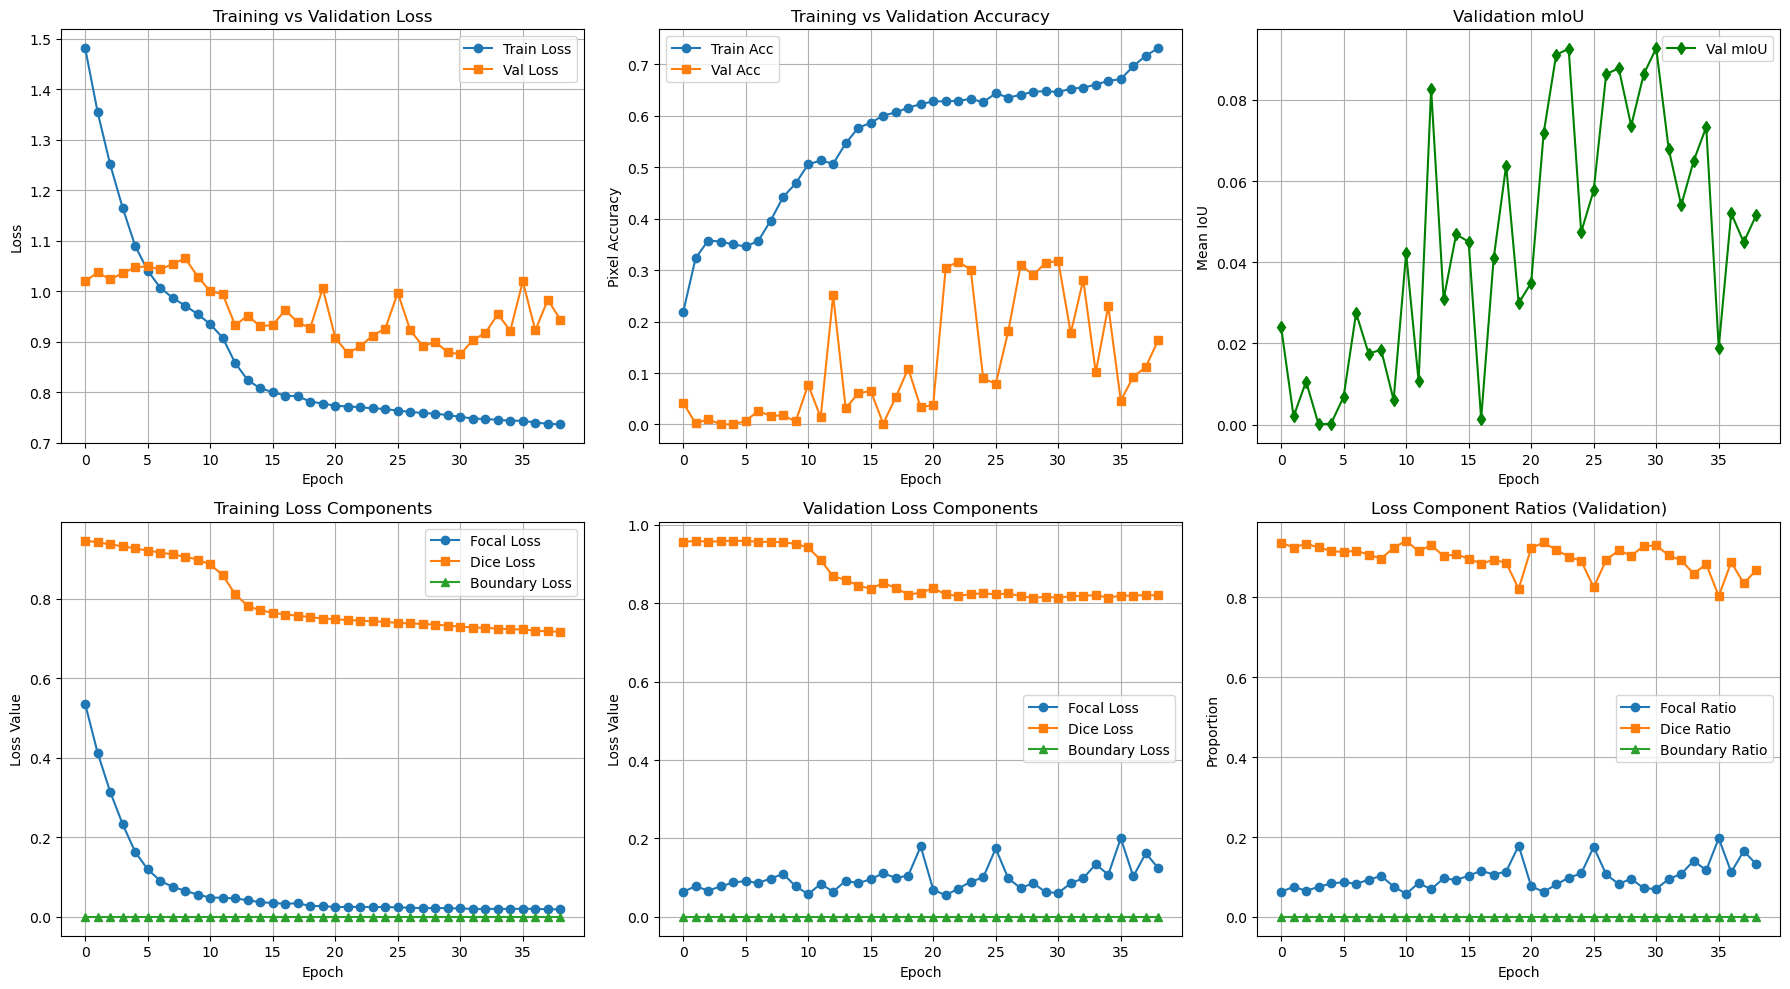

In [12]:
# ===========================================
# Cell 11. Plot Training History (Enhanced)
# ===========================================

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Loss
axes[0, 0].plot(history["train_loss"], label="Train Loss", marker='o')
axes[0, 0].plot(history["val_loss"], label="Val Loss", marker='s')
axes[0, 0].set_xlabel("Epoch")
axes[0, 0].set_ylabel("Loss")
axes[0, 0].set_title("Training vs Validation Loss")
axes[0, 0].legend()
axes[0, 0].grid(True)

# Accuracy
axes[0, 1].plot(history["train_acc"], label="Train Acc", marker='o')
axes[0, 1].plot(history["val_acc"], label="Val Acc", marker='s')
axes[0, 1].set_xlabel("Epoch")
axes[0, 1].set_ylabel("Pixel Accuracy")
axes[0, 1].set_title("Training vs Validation Accuracy")
axes[0, 1].legend()
axes[0, 1].grid(True)

# mIoU
axes[0, 2].plot(history["val_miou"], label="Val mIoU", marker='d', color='green')
axes[0, 2].set_xlabel("Epoch")
axes[0, 2].set_ylabel("Mean IoU")
axes[0, 2].set_title("Validation mIoU")
axes[0, 2].legend()
axes[0, 2].grid(True)

# Loss Components - Training
axes[1, 0].plot(history["train_loss_focal"], label="Focal Loss", marker='o')
axes[1, 0].plot(history["train_loss_dice"], label="Dice Loss", marker='s')
axes[1, 0].plot(history["train_loss_boundary"], label="Boundary Loss", marker='^')
axes[1, 0].set_xlabel("Epoch")
axes[1, 0].set_ylabel("Loss Value")
axes[1, 0].set_title("Training Loss Components")
axes[1, 0].legend()
axes[1, 0].grid(True)

# Loss Components - Validation
axes[1, 1].plot(history["val_loss_focal"], label="Focal Loss", marker='o')
axes[1, 1].plot(history["val_loss_dice"], label="Dice Loss", marker='s')
axes[1, 1].plot(history["val_loss_boundary"], label="Boundary Loss", marker='^')
axes[1, 1].set_xlabel("Epoch")
axes[1, 1].set_ylabel("Loss Value")
axes[1, 1].set_title("Validation Loss Components")
axes[1, 1].legend()
axes[1, 1].grid(True)

# Loss ratio analysis
if len(history["val_loss_focal"]) > 0:
    total = np.array(history["val_loss_focal"]) + np.array(history["val_loss_dice"]) + np.array(history["val_loss_boundary"])
    focal_ratio = np.array(history["val_loss_focal"]) / (total + 1e-9)
    dice_ratio = np.array(history["val_loss_dice"]) / (total + 1e-9)
    bnd_ratio = np.array(history["val_loss_boundary"]) / (total + 1e-9)
    
    axes[1, 2].plot(focal_ratio, label="Focal Ratio", marker='o')
    axes[1, 2].plot(dice_ratio, label="Dice Ratio", marker='s')
    axes[1, 2].plot(bnd_ratio, label="Boundary Ratio", marker='^')
    axes[1, 2].set_xlabel("Epoch")
    axes[1, 2].set_ylabel("Proportion")
    axes[1, 2].set_title("Loss Component Ratios (Validation)")
    axes[1, 2].legend()
    axes[1, 2].grid(True)

plt.tight_layout()
plt.savefig("training_history_ver5_enhanced.png", dpi=150)
plt.show()


Visualizing spectral attention weights...


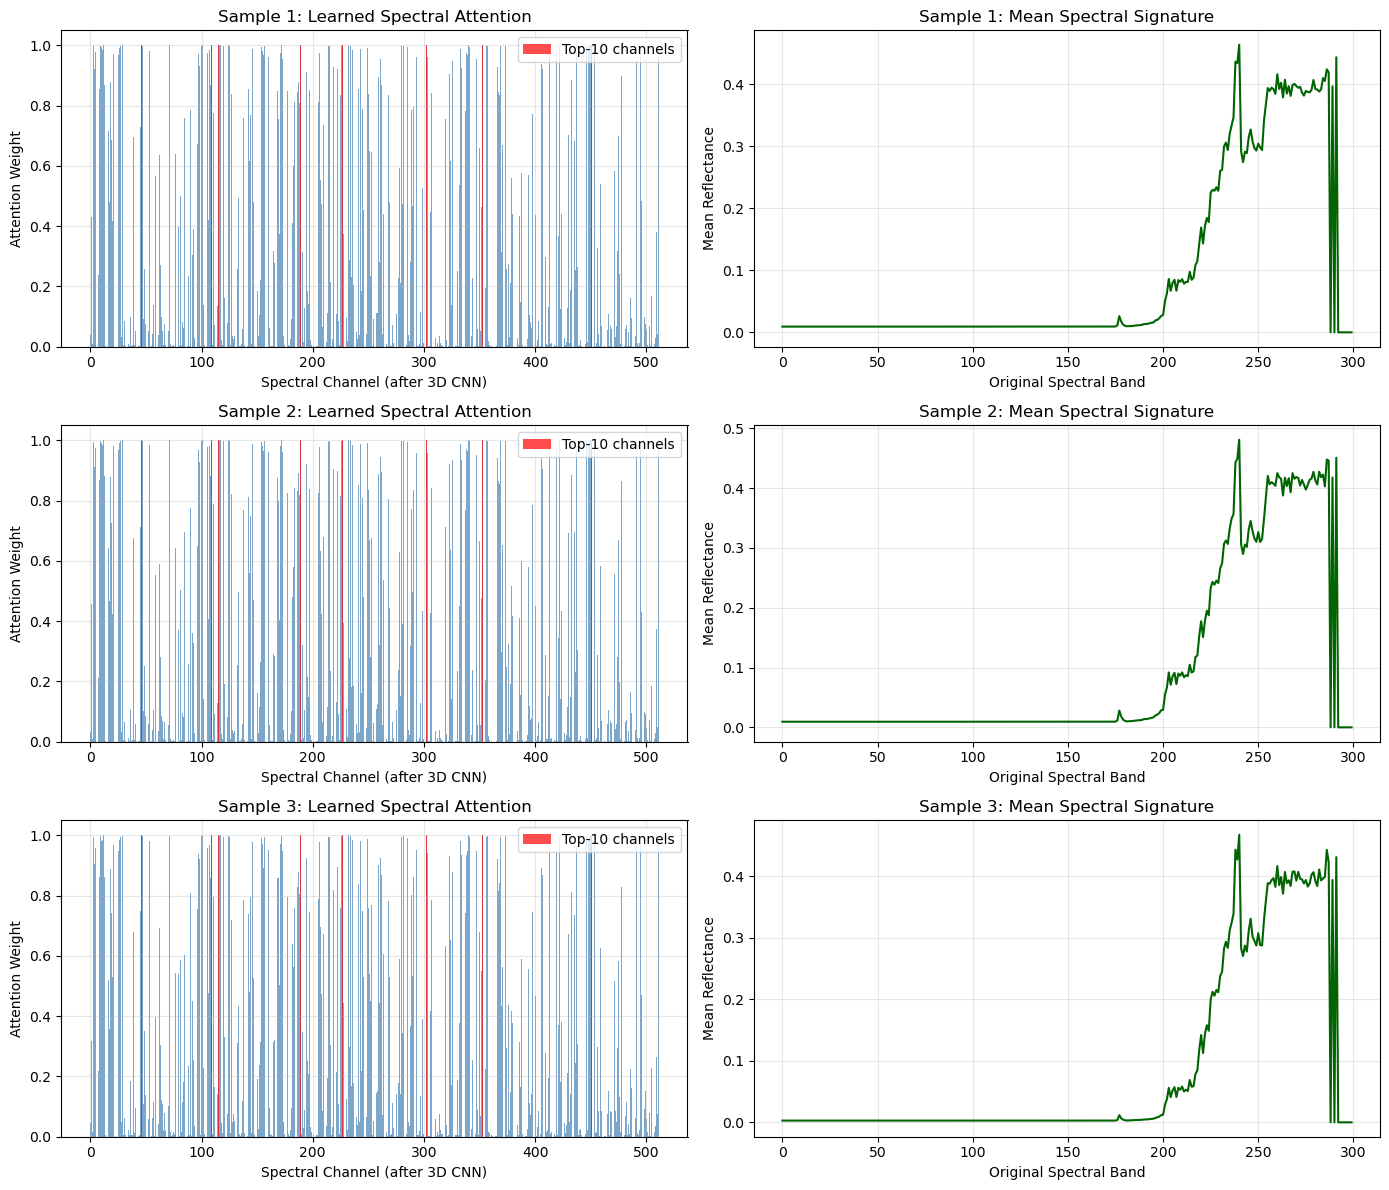


SPECTRAL ATTENTION ANALYSIS

Sample 1:
  Mean attention: 0.3596
  Std attention: 0.3998
  Max attention: 1.0000
  Top-5 channels: [318 451 227 381  46] with weights [0.99999285 0.9999943  0.99999535 0.9999975  0.99999964]

Sample 2:
  Mean attention: 0.3592
  Std attention: 0.3993
  Max attention: 1.0000
  Top-5 channels: [318 227 451 381  46] with weights [0.9999926  0.9999939  0.99999416 0.99999785 0.9999995 ]

Sample 3:
  Mean attention: 0.3646
  Std attention: 0.3906
  Max attention: 1.0000
  Top-5 channels: [109 318 227 381  46] with weights [0.9999608  0.99996686 0.9999734  0.9999882  0.9999981 ]


In [13]:
# ===========================================
# Cell 12. Spectral Attention Visualization
# ===========================================

def visualize_spectral_attention(model, loader, num_samples=3):
    """Visualize learned spectral attention weights"""
    model.eval()
    
    attention_weights_list = []
    sample_images = []
    
    with torch.no_grad():
        for i, (xb, yb) in enumerate(loader):
            if i >= num_samples:
                break
            
            xb = xb.to(device)
            _ = model(xb)  # Forward pass
            
            # Get attention weights
            attn_weights = model.get_attention_weights()
            if attn_weights is not None:
                attention_weights_list.append(attn_weights[0].cpu().numpy())
                sample_images.append(xb[0])
    
    if not attention_weights_list:
        print("No attention weights captured!")
        return
    
    # Plot attention weights
    fig, axes = plt.subplots(num_samples, 2, figsize=(14, 4*num_samples))
    
    for i in range(num_samples):
        # Attention weights
        attn = attention_weights_list[i]
        axes[i, 0].bar(range(len(attn)), attn, color='steelblue', alpha=0.7)
        axes[i, 0].set_xlabel("Spectral Channel (after 3D CNN)")
        axes[i, 0].set_ylabel("Attention Weight")
        axes[i, 0].set_title(f"Sample {i+1}: Learned Spectral Attention")
        axes[i, 0].grid(True, alpha=0.3)
        
        # Top-k important channels
        top_k = 10
        top_indices = np.argsort(attn)[-top_k:]
        axes[i, 0].bar(top_indices, attn[top_indices], color='red', alpha=0.7, 
                       label=f'Top-{top_k} channels')
        axes[i, 0].legend()
        
        # Original hyperspectral signature (averaged)
        img = sample_images[i].cpu().numpy()  # [Bands, H, W]
        mean_spectrum = img.mean(axis=(1, 2))
        
        axes[i, 1].plot(mean_spectrum, color='darkgreen', linewidth=1.5)
        axes[i, 1].set_xlabel("Original Spectral Band")
        axes[i, 1].set_ylabel("Mean Reflectance")
        axes[i, 1].set_title(f"Sample {i+1}: Mean Spectral Signature")
        axes[i, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig("spectral_attention_weights_ver5.png", dpi=150)
    plt.show()
    
    # Print statistics
    print("\n" + "="*60)
    print("SPECTRAL ATTENTION ANALYSIS")
    print("="*60)
    for i, attn in enumerate(attention_weights_list):
        top_5_idx = np.argsort(attn)[-5:]
        print(f"\nSample {i+1}:")
        print(f"  Mean attention: {attn.mean():.4f}")
        print(f"  Std attention: {attn.std():.4f}")
        print(f"  Max attention: {attn.max():.4f}")
        print(f"  Top-5 channels: {top_5_idx} with weights {attn[top_5_idx]}")

# Visualize attention on validation set
print("\nVisualizing spectral attention weights...")
visualize_spectral_attention(model, val_loader, num_samples=3)

C:\Users\admin\AppData\Local\Temp\ipykernel_17948\4152879093.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_checkpoint = torch.load(best_model_path, map_location=d

Loaded best model from epoch 31



TEST RESULTS
Test Loss     : 0.8898
  ├─ Focal Loss  : 0.0780
  ├─ Dice Loss: 0.8117
  └─ Bnd Loss : 0.0000
Test Accuracy : 0.3390
Test mIoU     : 0.0847
IoU per class : [0.         0.         0.33896545 0.         0.         0.        ]

GENERATING SEGMENTATION MAPS
Sample 1: Input shape torch.Size([1, 300, 64, 64]), Output shape torch.Size([1, 64, 64])
Sample 2: Input shape torch.Size([1, 300, 64, 64]), Output shape torch.Size([1, 64, 64])
Sample 3: Input shape torch.Size([1, 300, 64, 64]), Output shape torch.Size([1, 64, 64])
Sample 4: Input shape torch.Size([1, 300, 64, 64]), Output shape torch.Size([1, 64, 64])
Sample 5: Input shape torch.Size([1, 300, 64, 64]), Output shape torch.Size([1, 64, 64])

Generating visualizations...
Visualizing sample 1/5


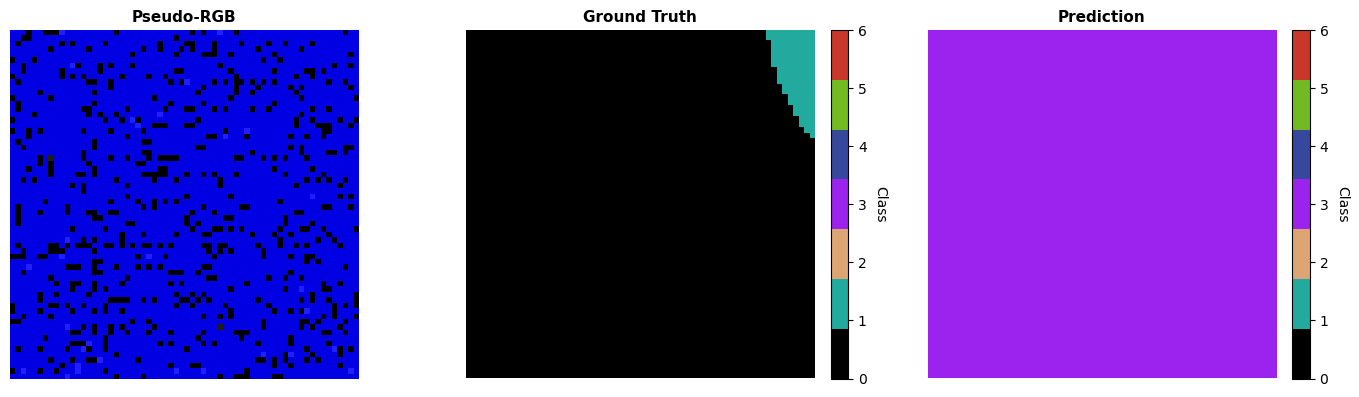

Visualizing sample 2/5


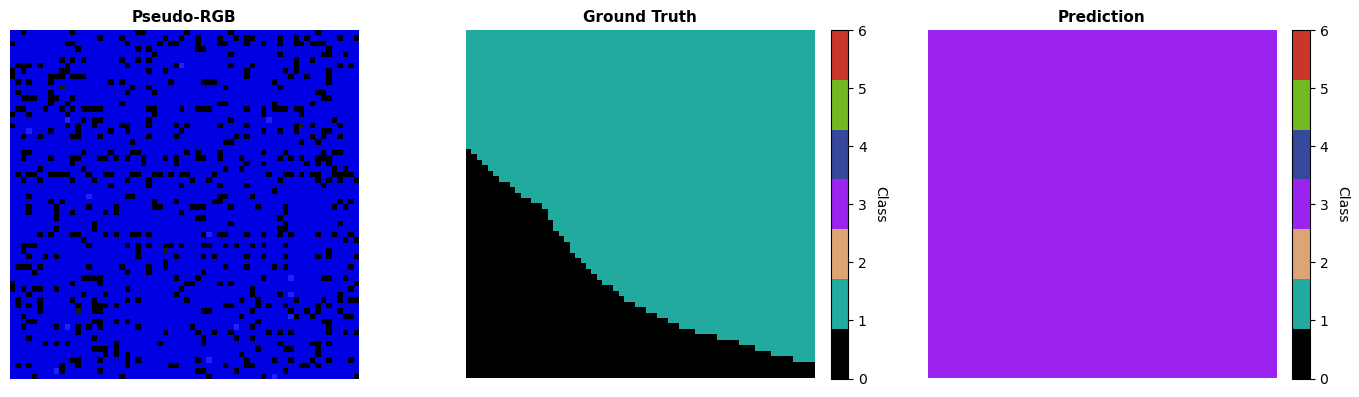

Visualizing sample 3/5


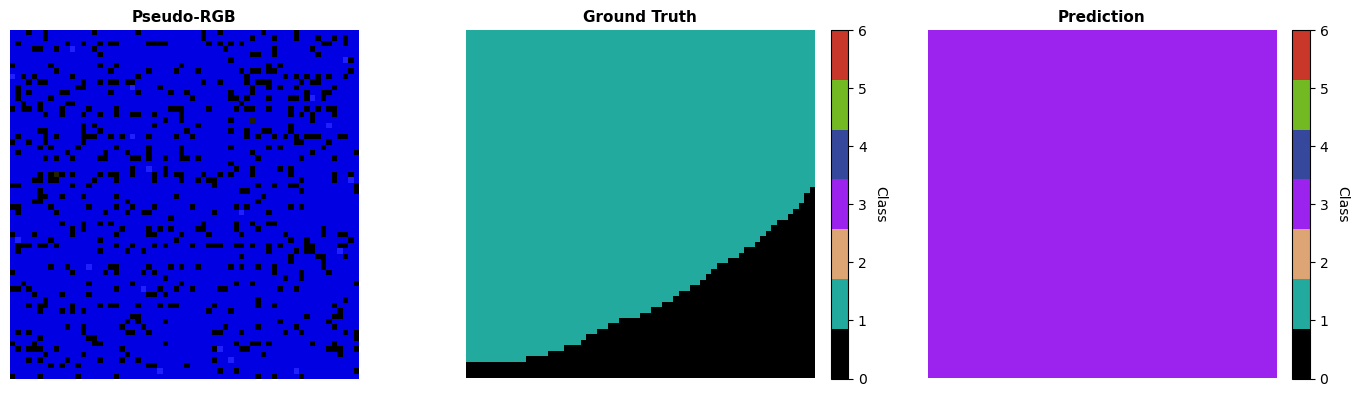

Visualizing sample 4/5


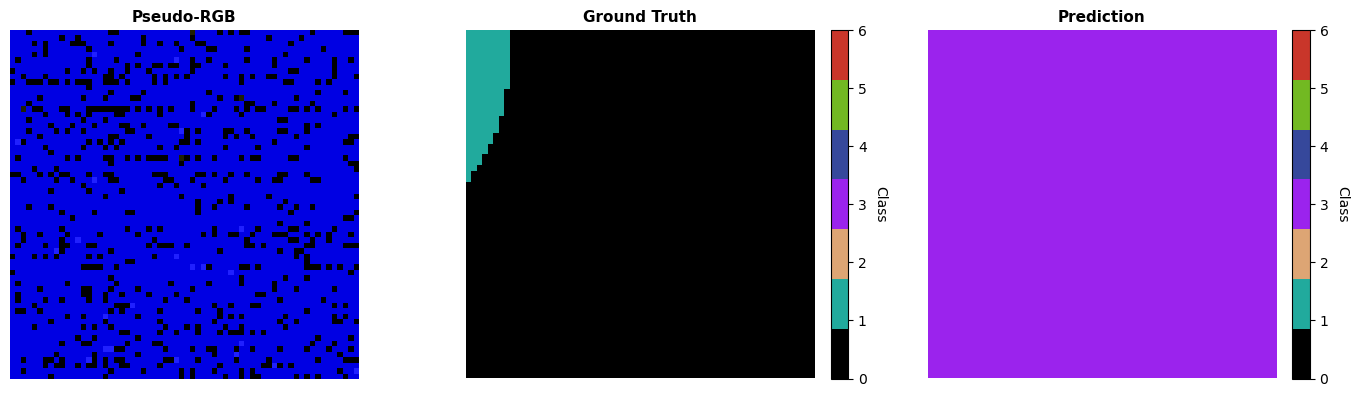

Visualizing sample 5/5


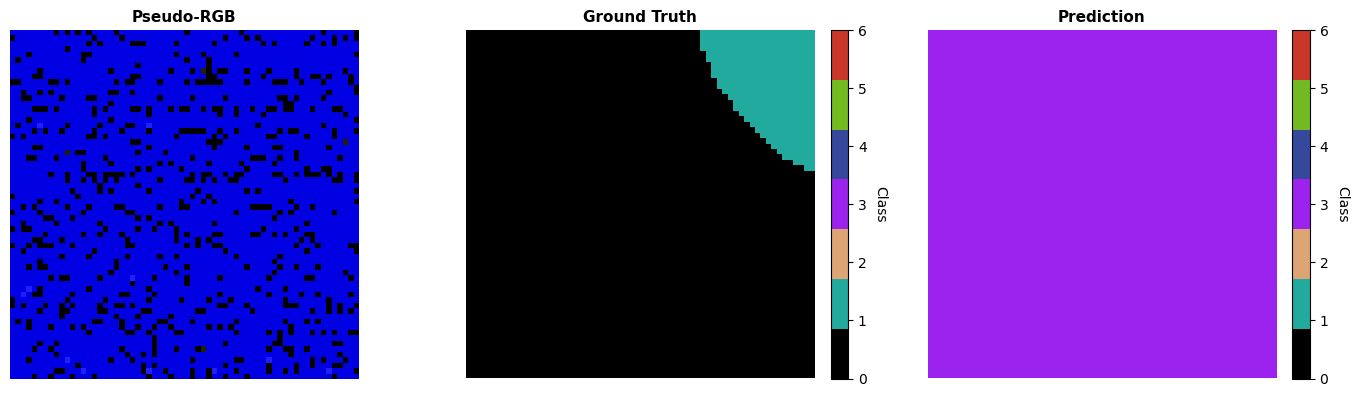


[OK] Output: SEGMENTATION MAPS
  Format: [H, W] dengan setiap pixel berisi class label (0-6)
  Visualisasi: Setiap warna merepresentasikan habitat class berbeda


In [14]:
# ===========================================
# Cell 13. Testing dan Visualisasi Output Segmentation
# ===========================================

# Load best model
best_checkpoint = torch.load(best_model_path, map_location=device)
model.load_state_dict(best_checkpoint["model_state"])
print(f"Loaded best model from epoch {best_checkpoint['epoch']}")

# Test evaluation
test_metrics = SegmentationMetrics(num_classes_actual, ignore_index=0)
test_loss, test_acc, test_miou, test_iou_per_class, test_focal, test_dice, test_bnd = validate(
    model, test_loader, criterion, test_metrics, device
)

print("\n" + "="*60)
print("TEST RESULTS")
print("="*60)
print(f"Test Loss     : {test_loss:.4f}")
print(f"  ├─ Focal Loss  : {test_focal:.4f}") # rename ce menjadi focal 
print(f"  ├─ Dice Loss: {test_dice:.4f}")
print(f"  └─ Bnd Loss : {test_bnd:.4f}")
print(f"Test Accuracy : {test_acc:.4f}")
print(f"Test mIoU     : {test_miou:.4f}")
print(f"IoU per class : {test_iou_per_class[1:]}")

# Visualisasi beberapa prediksi SEGMENTATION MAP
model.eval()
num_vis = 5
vis_samples = []

print("\n" + "="*60)
print("GENERATING SEGMENTATION MAPS")
print("="*60)

with torch.no_grad():
    for i, (xb, yb) in enumerate(test_loader):
        if i >= num_vis:
            break
        xb = xb.to(device)
        logits = model(xb)
        preds = logits.argmax(dim=1)  # [B, H, W] - SEGMENTATION MAP
        
        vis_samples.append((xb[0], yb[0], preds[0]))
        print(f"Sample {i+1}: Input shape {xb.shape}, Output shape {preds.shape}")

# Plot visualisasi segmentation maps
print("\nGenerating visualizations...")
for i, (x, y_true, y_pred) in enumerate(vis_samples):
    print(f"Visualizing sample {i+1}/{num_vis}")
    visualize_tile(x, y_true.cpu().numpy(), y_pred.cpu().numpy(), 
                   cmap=global_cmap, idx=i)

print("\n[OK] Output: SEGMENTATION MAPS")
print("  Format: [H, W] dengan setiap pixel berisi class label (0-6)")
print("  Visualisasi: Setiap warna merepresentasikan habitat class berbeda")

Computing CM: 100%|████████████████████████████████████████████████████████████████| 1286/1286 [00:24<00:00, 53.04it/s]


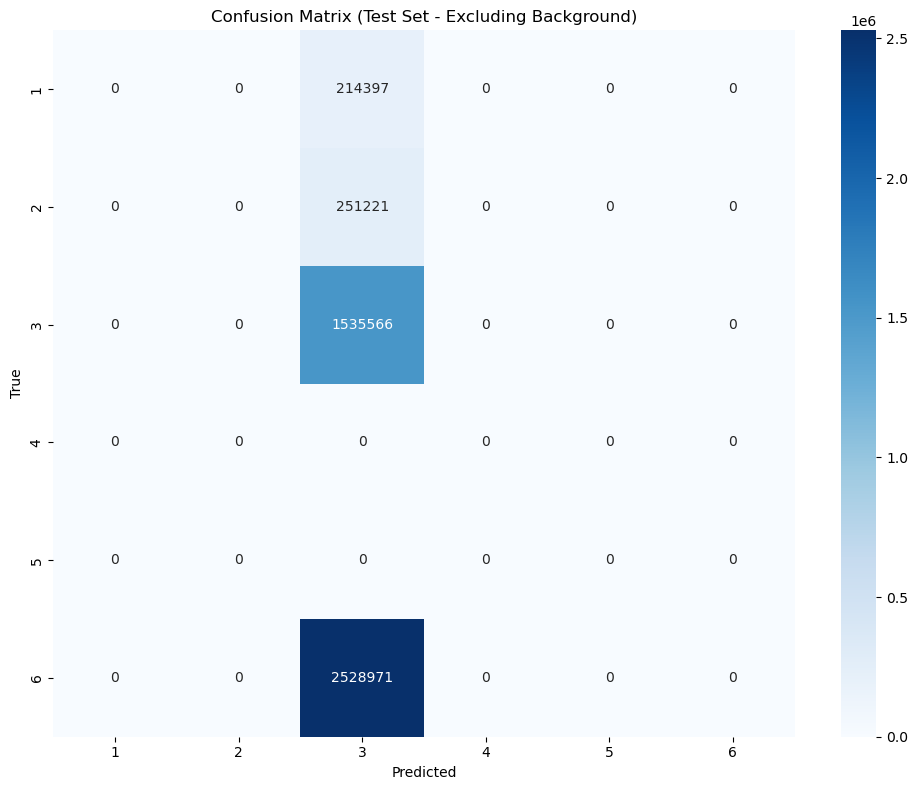

Confusion matrix saved!


In [15]:
# ===========================================
# Cell 14. Confusion Matrix
# ===========================================

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Collect predictions untuk confusion matrix
all_preds = []
all_targets = []

model.eval()
with torch.no_grad():
    for xb, yb in tqdm(test_loader, desc="Computing CM"):
        xb = xb.to(device)
        logits = model(xb)
        preds = logits.argmax(dim=1)
        
        # Flatten dan filter valid pixels
        preds_flat = preds.cpu().numpy().flatten()
        targets_flat = yb.numpy().flatten()
        
        valid = targets_flat != 0  # Exclude background
        all_preds.extend(preds_flat[valid])
        all_targets.extend(targets_flat[valid])

# Compute confusion matrix
cm = confusion_matrix(all_targets, all_preds, labels=list(range(1, num_classes_actual)))

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(1, num_classes_actual),
            yticklabels=range(1, num_classes_actual))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test Set - Excluding Background)')
plt.tight_layout()
plt.savefig('confusion_matrix_ver5.png', dpi=150)
plt.show()

print("Confusion matrix saved!")


FULL IMAGE SEGMENTATION
Selected image: massimal_smola_maholmen_202306211228-2_hsi_005_processed_x.npy
[INFO] Loading full image from: ../data/npy_converted\massimal_smola_maholmen_202306211228-2_hsi_005_processed_x.npy
[INFO] Image shape: (971, 900, 300)
[INFO] Processing 783 tiles (29x27)...
  Processed 100/783 tiles (12.8%)
  Processed 200/783 tiles (25.5%)
  Processed 300/783 tiles (38.3%)
  Processed 400/783 tiles (51.1%)
  Processed 500/783 tiles (63.9%)
  Processed 600/783 tiles (76.6%)
  Processed 700/783 tiles (89.4%)
[INFO] Segmentation complete!
[INFO] Unique classes predicted: [0 3 5]
[INFO] Ground truth loaded. Unique classes: [0 8]

[METRICS] Full Image:
  Pixel Accuracy: 0.0000
  Mean IoU: nan
  IoU per class: [np.float64(0.0), 0.0, np.float64(0.0), 0.0, np.float64(0.0), 0.0]


C:\Users\admin\miniconda3\envs\algae\lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\admin\miniconda3\envs\algae\lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


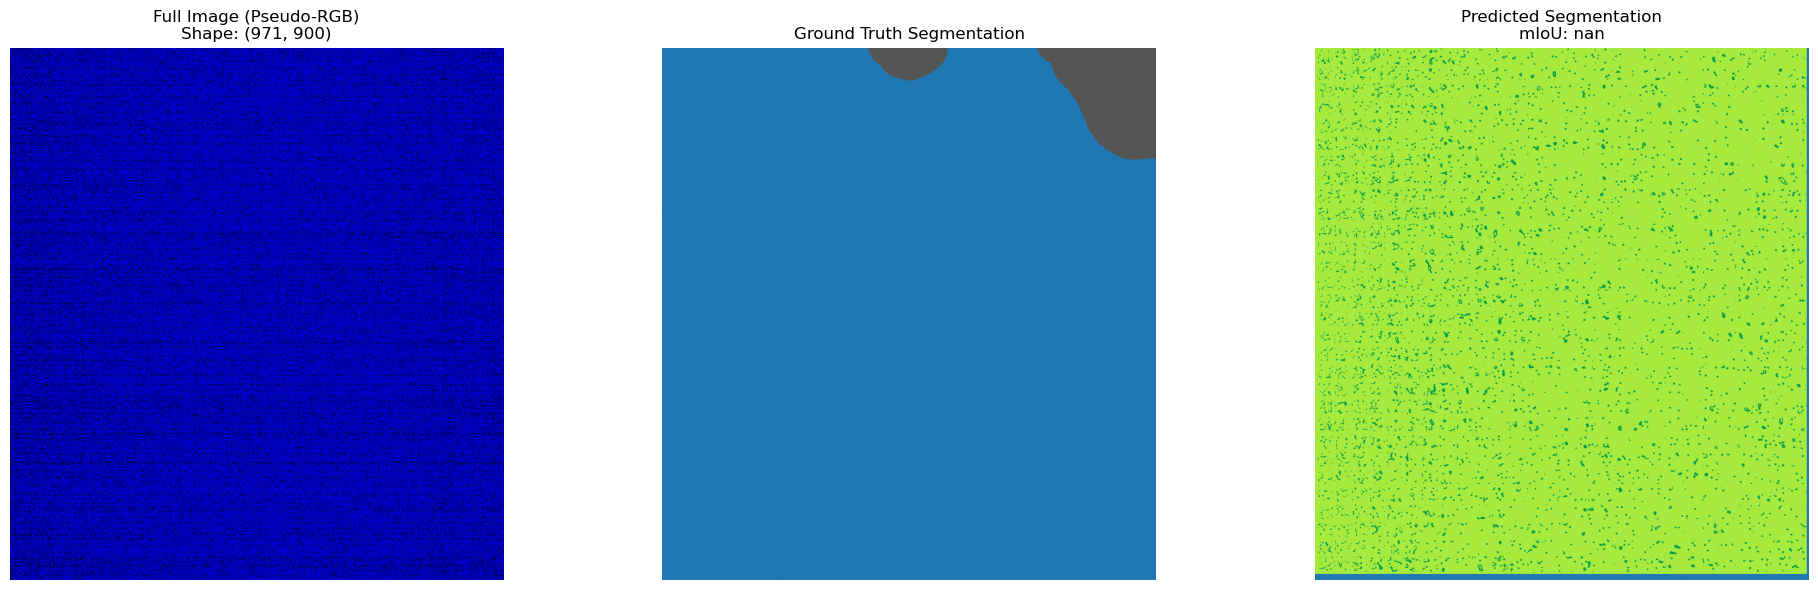


[OK] Full image segmentation saved!
  Resolution: (971, 900)
  File: full_image_segmentation_ver5.png

BATCH FULL IMAGE SEGMENTATION (ALL TEST IMAGES)

Processing image 1/6: massimal_smola_maholmen_202306211228-2_hsi_005_processed_x.npy
[INFO] Loading full image from: ../data/npy_converted\massimal_smola_maholmen_202306211228-2_hsi_005_processed_x.npy
[INFO] Image shape: (971, 900, 300)
[INFO] Processing 783 tiles (29x27)...
  Processed 100/783 tiles (12.8%)
  Processed 200/783 tiles (25.5%)
  Processed 300/783 tiles (38.3%)
  Processed 400/783 tiles (51.1%)
  Processed 500/783 tiles (63.9%)
  Processed 600/783 tiles (76.6%)
  Processed 700/783 tiles (89.4%)
[INFO] Segmentation complete!
[INFO] Unique classes predicted: [0 3 5]
[INFO] Ground truth loaded. Unique classes: [0 8]
  [OK] Saved: full_image_seg_test_1.png

Processing image 2/6: massimal_smola_maholmen_202306211228-2_hsi_009_processed_x.npy
[INFO] Loading full image from: ../data/npy_converted\massimal_smola_maholmen_2023062

In [16]:
# ===========================================
# Cell 15. Full Image Segmentation with Sliding Window
# ===========================================

def segment_full_image(model, image_path, mask_path=None, tile_size=64, stride=32, device='cuda'):
    """
    Segmentasi full image dengan sliding window approach
    
    Args:
        model: trained segmentation model
        image_path: path ke file _x.npy
        mask_path: path ke file _y.npy (optional, untuk comparison)
        tile_size: ukuran tile untuk inference
        stride: step size untuk sliding window (stride < tile_size untuk smooth overlap)
        device: 'cuda' or 'cpu'
    
    Returns:
        prediction_map: segmentation result [H, W]
        full_image: original image [H, W, Bands]
        ground_truth: GT mask if mask_path provided, else None
    """
    model.eval()
    
    print(f"[INFO] Loading full image from: {image_path}")
    
    # Load full image
    x_full = np.load(image_path, mmap_mode='r')  # [H, W, Bands]
    H, W, B = x_full.shape
    print(f"[INFO] Image shape: {x_full.shape}")
    
    # Normalize
    x_full_norm = normalize_reflectance(x_full.copy())
    
    # Prepare output with soft voting
    prediction_accumulator = np.zeros((num_classes_actual, H, W), dtype=np.float32)
    count_map = np.zeros((H, W), dtype=np.float32)
    
    # Calculate number of tiles
    n_tiles_h = (H - tile_size) // stride + 1
    n_tiles_w = (W - tile_size) // stride + 1
    total_tiles = n_tiles_h * n_tiles_w
    
    print(f"[INFO] Processing {total_tiles} tiles ({n_tiles_h}x{n_tiles_w})...")
    
    with torch.no_grad():
        tile_count = 0
        for i in range(0, H - tile_size + 1, stride):
            for j in range(0, W - tile_size + 1, stride):
                # Extract tile
                tile = x_full_norm[i:i+tile_size, j:j+tile_size, :]
                tile_tensor = torch.from_numpy(tile.transpose(2,0,1)).unsqueeze(0).float().to(device)
                
                # Predict
                logits = model(tile_tensor)  # [1, C, H, W]
                probs = F.softmax(logits, dim=1).squeeze(0).cpu().numpy()  # [C, H, W]
                
                # Accumulate predictions (soft voting)
                prediction_accumulator[:, i:i+tile_size, j:j+tile_size] += probs
                count_map[i:i+tile_size, j:j+tile_size] += 1
                
                tile_count += 1
                if tile_count % 100 == 0:
                    print(f"  Processed {tile_count}/{total_tiles} tiles ({tile_count/total_tiles*100:.1f}%)")
    
    # Average overlapping predictions and get argmax
    prediction_accumulator /= (count_map[np.newaxis, :, :] + 1e-9)
    final_pred = prediction_accumulator.argmax(axis=0).astype(np.int32)
    
    print(f"[INFO] Segmentation complete!")
    print(f"[INFO] Unique classes predicted: {np.unique(final_pred)}")
    
    # Load ground truth if provided
    ground_truth = None
    if mask_path and os.path.exists(mask_path):
        ground_truth = np.load(mask_path)
        print(f"[INFO] Ground truth loaded. Unique classes: {np.unique(ground_truth)}")
        
        # Remap ground truth
        if label_remap is not None:
            gt_remap = np.zeros_like(ground_truth, dtype=np.int32)
            for orig_label, new_idx in label_remap.items():
                gt_remap[ground_truth == orig_label] = new_idx
            ground_truth = gt_remap
    
    return final_pred, x_full, ground_truth


# Visualize full image segmentation
print("\n" + "="*60)
print("FULL IMAGE SEGMENTATION")
print("="*60)

# Select a test image
test_file_idx = 0  # Change this to visualize different images
test_file_x = test_pairs[test_file_idx][0]
test_file_y = test_pairs[test_file_idx][1]

print(f"Selected image: {os.path.basename(test_file_x)}")

# Perform segmentation
full_pred, full_img, full_gt = segment_full_image(
    model, 
    test_file_x, 
    test_file_y,
    tile_size=TILE_SIZE, 
    stride=TILE_SIZE // 2,  # 50% overlap
    device=device
)

# Calculate metrics for full image
if full_gt is not None:
    valid_mask = (full_gt != 0)
    if valid_mask.sum() > 0:
        valid_pred = full_pred[valid_mask]
        valid_gt = full_gt[valid_mask]
        
        full_acc = (valid_pred == valid_gt).sum() / len(valid_pred)
        
        # Calculate IoU per class
        full_iou_per_class = []
        for cls in range(1, num_classes_actual):
            pred_i = (valid_pred == cls)
            gt_i = (valid_gt == cls)
            intersection = (pred_i & gt_i).sum()
            union = (pred_i | gt_i).sum()
            iou = intersection / (union + 1e-9) if union > 0 else 0.0
            full_iou_per_class.append(iou)
        
        full_miou = np.mean([iou for iou in full_iou_per_class if iou > 0])
        
        print(f"\n[METRICS] Full Image:")
        print(f"  Pixel Accuracy: {full_acc:.4f}")
        print(f"  Mean IoU: {full_miou:.4f}")
        print(f"  IoU per class: {full_iou_per_class}")

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Pseudo-RGB
rgb_idx = [int(full_img.shape[2]*0.05), int(full_img.shape[2]*0.5), int(full_img.shape[2]*0.9)]
rgb = full_img[..., rgb_idx]
rgb_norm = (rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-9)

# Load colormap
if os.path.exists(label_json_path):
    with open(label_json_path, "r") as f:
        label_info = json.load(f)
    custom_colors = [c["color"][:7] for c in label_info]
    cmap = ListedColormap(custom_colors)
else:
    cmap = "tab20"

axes[0].imshow(rgb_norm)
axes[0].set_title(f"Full Image (Pseudo-RGB)\nShape: {full_img.shape[:2]}", fontsize=12)
axes[0].axis('off')

if full_gt is not None:
    axes[1].imshow(full_gt, cmap=cmap, vmin=0, vmax=num_classes_actual-1)
    axes[1].set_title("Ground Truth Segmentation", fontsize=12)
    axes[1].axis('off')

axes[2].imshow(full_pred, cmap=cmap, vmin=0, vmax=num_classes_actual-1)
axes[2].set_title(f"Predicted Segmentation\nmIoU: {full_miou:.3f}" if full_gt is not None else "Predicted Segmentation", fontsize=12)
axes[2].axis('off')

plt.tight_layout()
plt.savefig('full_image_segmentation_ver5.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n[OK] Full image segmentation saved!")
print(f"  Resolution: {full_pred.shape}")
print(f"  File: full_image_segmentation_ver5.png")


# Optional: Visualize multiple test images
print("\n" + "="*60)
print("BATCH FULL IMAGE SEGMENTATION (ALL TEST IMAGES)")
print("="*60)

for idx, (fx, fy) in enumerate(test_pairs):
    print(f"\nProcessing image {idx+1}/{len(test_pairs)}: {os.path.basename(fx)}")
    
    pred, img, gt = segment_full_image(
        model, fx, fy,
        tile_size=TILE_SIZE,
        stride=TILE_SIZE // 2,
        device=device
    )
    
    # Create visualization
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    rgb_idx = [int(img.shape[2]*0.05), int(img.shape[2]*0.5), int(img.shape[2]*0.9)]
    rgb = img[..., rgb_idx]
    rgb_norm = (rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-9)
    
    axes[0].imshow(rgb_norm)
    axes[0].set_title(f"Image {idx+1}: Pseudo-RGB")
    axes[0].axis('off')
    
    if gt is not None:
        axes[1].imshow(gt, cmap=cmap)
        axes[1].set_title("Ground Truth")
        axes[1].axis('off')
    
    axes[2].imshow(pred, cmap=cmap)
    axes[2].set_title("Prediction")
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.savefig(f'full_image_seg_test_{idx+1}.png', dpi=120, bbox_inches='tight')
    plt.close()
    
    print(f"  [OK] Saved: full_image_seg_test_{idx+1}.png")

print("\n[OK] All test images processed!")
print(f"[OK] Generated {len(test_pairs)} full segmentation maps")


In [ ]:
# ===========================================
# Cell 15b. Dataset Distribution Analysis (untuk solusi test set issue)
# ===========================================

print("\n" + "="*60)
print("DATASET CLASS DISTRIBUTION ANALYSIS")
print("="*60)

def analyze_file_distribution(pairs, split_name):
    """Analisis distribusi kelas per file"""
    print(f"\n{split_name} Split Analysis:")
    print(f"{'='*50}")
    
    file_class_info = []
    
    for idx, (fx, fy) in enumerate(pairs):
        y = np.load(fy, mmap_mode='r')
        unique, counts = np.unique(y, return_counts=True)
        
        # Convert to dict
        class_dist = dict(zip(unique.tolist(), counts.tolist()))
        
        # Get remapped classes
        remapped_dist = {}
        for orig, cnt in class_dist.items():
            if orig in label_remap:
                new_idx = label_remap[orig]
                remapped_dist[new_idx] = cnt
        
        file_class_info.append({
            'file': os.path.basename(fx),
            'distribution': remapped_dist,
            'classes_present': sorted(remapped_dist.keys())
        })
        
        print(f"\nFile {idx+1}: {os.path.basename(fx)}")
        print(f"  Classes present: {sorted(remapped_dist.keys())}")
        print(f"  Pixel counts: {remapped_dist}")
    
    # Summary
    all_classes = set()
    for info in file_class_info:
        all_classes.update(info['classes_present'])
    
    print(f"\n{split_name} Summary:")
    print(f"  Total files: {len(pairs)}")
    print(f"  Classes covered: {sorted(all_classes)}")
    print(f"  Missing classes: {set(range(num_classes_actual)) - all_classes}")
    
    return file_class_info

# Analyze all splits
train_analysis = analyze_file_distribution(train_pairs, "TRAIN")
val_analysis = analyze_file_distribution(val_pairs, "VALIDATION")
test_analysis = analyze_file_distribution(test_pairs, "TEST")

# Check coverage
print("\n" + "="*60)
print("OVERALL COVERAGE CHECK")
print("="*60)

all_train_classes = set()
all_val_classes = set()
all_test_classes = set()

for info in train_analysis:
    all_train_classes.update(info['classes_present'])
for info in val_analysis:
    all_val_classes.update(info['classes_present'])
for info in test_analysis:
    all_test_classes.update(info['classes_present'])

print(f"\nClasses in Train: {sorted(all_train_classes)}")
print(f"Classes in Val:   {sorted(all_val_classes)}")
print(f"Classes in Test:  {sorted(all_test_classes)}")

missing_in_test = all_train_classes - all_test_classes
if missing_in_test:
    print(f"\n [WARNING]: Classes {sorted(missing_in_test)} are in TRAIN but NOT in TEST!")
    print(f"   This means we cannot evaluate model performance on these classes.")
    
    # Suggest rebalancing
    print(f"\n💡 RECOMMENDATION:")
    print(f"   Option 1: Move files from train/val to test that contain classes {sorted(missing_in_test)}")
    
    # Find files in train that have missing classes
    candidate_files = []
    for info in train_analysis:
        if missing_in_test & set(info['classes_present']):
            candidate_files.append((info['file'], info['classes_present']))
    
    if candidate_files:
        print(f"\n   Candidate files to move to test set:")
        for fname, classes in candidate_files[:3]:  # Show top 3
            print(f"     - {fname}: has classes {sorted(classes)}")
else:
    print(f"\n✓ All classes are represented in test set!")

In [ ]:
# ===========================================
# Cell 17. Save Results Summary
# ===========================================

results_summary = {
    "model": "SpectralAttentionHybridSN",
    "version": "v4_improved",
    "novelties": ["Spectral Self-Attention", "Multi-Objective Loss (Focal+Dice+Boundary)"],
    "improvements": [
        "Learning rate: 5e-6 → 1e-4",
        "Tile size: 32 → 64",
        "Boundary loss weight: 0.5 → 0.1",
        "Data augmentation: flip + rotation",
        "Focal loss replacing CE",
        "Early stopping patience: 10 → 15"
    ],
    "hyperparameters": {
        "learning_rate": LR,
        "batch_size": BATCH_SIZE,
        "accumulation_steps": ACCUMULATION_STEPS,
        "tile_size": TILE_SIZE,
        "num_epochs": NUM_EPOCHS,
        "attention_reduction": 16,
        "loss_weights": {"focal": 1.0, "dice": 1.0, "boundary": 0.1},
        "focal_gamma": 2.0,
        "early_stopping_patience": 15
    },
    "test_results": {
        "pixel_accuracy": float(test_acc),
        "mean_iou": float(test_miou),
        "loss_total": float(test_loss),
        "loss_focal": float(test_focal),
        "loss_dice": float(test_dice),
        "loss_boundary": float(test_bnd),
        "iou_per_class": test_iou_per_class.tolist()
    },
    "training_history": history
}

# Save to JSON
with open("results_ver5_summary.json", "w") as f:
    json.dump(results_summary, f, indent=2)

print("\n" + "="*60)
print("EXPERIMENT SUMMARY")
print("="*60)
print(json.dumps(results_summary["test_results"], indent=2))
print("\nResults saved to: results_ver5_summary.json")
print("\n[OK]Training complete!")